![Warning!  AI Generated Content](../posts/images/omgjjd_star_wars._robot_teaching_children._purple_details._norm_4dbf6075-53b0-47ef-90bc-ab2cc8cb7a86.png)

# Download some Libraries

In [1]:
!pip install polars floret gdown sentence-transformers tqdm pyarrow altair ipywidgets pandas matplotlib

  Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 78.8 MB/s eta 0:00:00
Using cached contourpy-1.3.1-cp313-cp313-macosx_11_0_arm64.whl (255 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 87.6 MB/s eta 0:00:00


# Download Some Free Spam

In [2]:
import polars as pl
dat = pl.read_csv("https://raw.githubusercontent.com/bigmlcom/python/refs/heads/master/data/spam.csv", separator = "\t")
dat.head()

Type,Message
str,str
"""ham""","""Go until jurong point, crazy..…"
"""ham""","""Ok lar... Joking wif u oni..."""
"""spam""","""Free entry in 2 a wkly comp to…"
"""ham""","""U dun say so early hor... U c …"
"""ham""","""Nah I don't think he goes to u…"


# Create Message Embeddings

In [3]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer("all-MiniLM-L6-v2")


In [4]:
df = dat.with_columns(   
    [pl.col("Message").map_elements(model.encode, return_dtype=pl.Object).alias("Message_embeddings")]
)
df.head(1)

shape: (1, 3)
┌──────┬─────────────────────────────────┬─────────────────────────────────┐
│ Type ┆ Message                         ┆ Message_embeddings              │
│ ---  ┆ ---                             ┆ ---                             │
│ str  ┆ str                             ┆ object                          │
╞══════╪═════════════════════════════════╪═════════════════════════════════╡
│ ham  ┆ Go until jurong point, crazy..… ┆ [-1.69181824e-02 -3.81679200e-… │
└──────┴─────────────────────────────────┴─────────────────────────────────┘

In [20]:
import polars as pl
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


# Load your Polars DataFrame (assuming it's already available)
# Example: df = pl.read_csv("your_data.csv") if reading from a file

# Convert labels to binary (spam = 1, ham = 0) and keep as a Polars expression
df = df.with_columns((pl.col("Type") == "spam").cast(pl.Int32).alias("Label"))

# Convert Polars columns directly to PyTorch tensors
X = torch.tensor(df["Message_embeddings"], dtype=torch.float32)  # Embeddings tensor
y = torch.tensor(df["Label"], dtype=torch.float32).unsqueeze(1)  # Labels tensor

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define logistic regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # Single output node
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))

# Initialize model
input_dim = X.shape[1]  # Get embedding size
model = LogisticRegression(input_dim)

# Define loss and optimizer
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50
holdout_metrics = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        # Evaluate the model on the holdout
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test)
            holdout_loss = criterion(y_pred, y_test)
            y_pred_labels = (y_pred > 0.5).float()  # Convert probabilities to binary (0 or 1)

        # Convert tensors to NumPy arrays for sklearn metrics
        y_test_np = y_test.numpy()
        y_pred_np = y_pred_labels.numpy()

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test_np, y_pred_np)
        metrics = {
            "epoch" : epoch,
            "loss" : loss.item(),
            "holdout_loss" : holdout_loss.item(),
            "holdout_accuracy" : accuracy,
        }
        holdout_metrics.append(metrics)

metrics = pd.DataFrame(holdout_metrics).set_index("epoch")
metrics

,loss,holdout_loss,holdout_accuracy
epoch,,,
0,0.694177,0.669596,0.833333
10,0.489731,0.485265,0.878788
20,0.374139,0.386231,0.878788
30,0.308182,0.332601,0.878788
40,0.264232,0.297609,0.886364


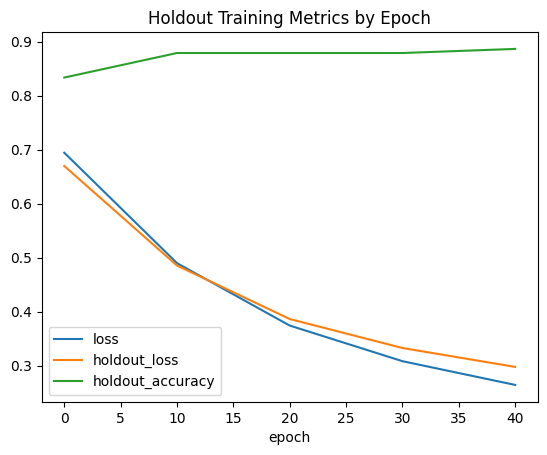

In [21]:
metrics.plot(title="Holdout Training Metrics by Epoch");